In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from datetime import datetime  
from datetime import timedelta, date
from scipy.optimize import fsolve
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
plt.style.use('seaborn')
%matplotlib inline

In [2]:
global_confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
global_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

US_confirmed_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
US_deaths_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv"

In [3]:
# Filter data by country
def clean_country(url1, url2):
    data1 = pd.read_csv(url1)
    data2 = pd.read_csv(url2)
    country_list = data1['Country/Region'].values
    country = str(input("Select a country: "))
    while not country in country_list:
        country = str(input("Cannot find that country. Try again: "))
    choice = data1['Country/Region'] == country
    data1 = data1[choice]
    data1 = data1.loc[:,'1/22/20':]
    data1 = data1.sum()
    data2 = data2[choice]
    data2 = data2.loc[:,'1/22/20':]
    data2 = data2.sum()
    days = list(range(0,len(data1)))
    return country, days, data1, data2

# Filter data by state in U.S
def clean_state(url1, url2):
    data1 = pd.read_csv(url1)
    data2 = pd.read_csv(url2)
    state_list = data1['Province_State'].values
    state = str(input("Select a U.S state: "))
    while not state in state_list:
        state = str(input("Cannot find that state. Try again: "))
    filtER = data1['Province_State'] == state
    data1 = data1[filtER]
    data2 = data2[filtER]
    data1 = data1.loc[:,'1/22/20':]
    data2 = data2.loc[:,'1/22/20':]
    data1 = data1.sum()
    data2 = data2.sum()
    days = list(range(0,len(data1)))
    return state, days, data1, data2

def convert_date(delta_list):
    dates = []
    t0 = date(2020,11,22)
    for i in delta_list:
        datez = t0 + timedelta(days = i)
        datez = datez.strftime("%m/%d/%Y")
        dates.append(datez)
    return dates

Reported confirmed,deaths, and recovered cases in the U.S.
 
This model's main assumption is human intervention. 

In [5]:
def logistic_model(t,k,t_star,M):
    return (M)/(1+np.exp(-(t-t_star)/k))

In [6]:
# The error function calculates the % error of yesterday's predictions vs. today's data
def error(function, x, y, z):
    #delta = today - t0
    fit = curve_fit(function, x[:-2], y[:-2])
    param = fit[0]
    rate = param[0]
    t_star = param[1]
    carry_cap = param[2]
    
    mortality_rate = (z[-2])/(y[-2]) # Latest total confirmed deaths / total confirmed cases
    predicted_deaths = mortality_rate * carry_cap
    
    #days_til_today = delta.days 
    pred_inf = logistic_model(x[-1], rate, t_star, carry_cap)
    
    inf_error = abs((pred_inf - y[-1])/y[-1])
    deaths_error = abs((predicted_deaths - z[-1])/ z[-1])
    return x[-1], pred_inf, inf_error, deaths_error

In [11]:
def analyze(function, x, y, z, location):
    t0 = date(2020,1,22)
    
    # Function will return rate of change, t* & carrying capacity
    fit = curve_fit(function, x, y)
    param = fit[0]
    cov = fit[1]
    rate = param[0]
    t_star = param[1]
    carry_cap = param[2]
    errors = [np.sqrt(cov[i][i]) for i in [0,1,2]]
    
    mortality_rate = (z[-1])/(y[-1]) # Latest total confirmed deaths / total confirmed cases
    exp_deaths = mortality_rate * carry_cap # Expected end date deaths = MR * Carrying Capacity
    
    # Printing out the data
    print("The current infected population in",location, "is", int(y[-1]))
    print("The current mortality rate is", round((mortality_rate*100),2),"%")
    print("The current infection rate is", int(rate))
    print("Today's number of new cases is", (y[-1] - y[-2]))
    
    if t_star < 365:
        t_starDate = t0 + timedelta(days = t_star)
        t_starDate= t_starDate.strftime("%m/%d/%Y")
        print("The date with the highest infection rate", t_starDate)
    elif t_star >= 365:
        print("The date with the highest infection rate cannot be calculated at this time.")
    print("The carrying capacity is", int(carry_cap), "+/-", int(errors[2]), "people")
    # Calculating the percentage error from yesterday's predictions
    days_til_today, pred_inf, inf_error, deaths_error = error(function, x, y, z)
    
    # Predicting tomorrow's infections & deaths
    tomorrow = date.today() + timedelta(days = 1)
    tomorrow_date = tomorrow.strftime("%m/%d/%Y")
    days_til_tomorrow = x[-1] + 1
    
    exp_inf = logistic_model(days_til_tomorrow, rate, t_star, carry_cap)
    tmr_exp_inf = abs(exp_inf - y[-1])
    
    print("The estimated number of new cases for", tomorrow_date, "is", int(tmr_exp_inf), "+/-", 
          int(inf_error*tmr_exp_inf), "people")
    
    tmr_exp_deaths = int(mortality_rate * (y[-1] - y[-2]))
    print("The estimated number of new deaths for", tomorrow_date, "is", tmr_exp_deaths,"+/-", 
        int(deaths_error*tmr_exp_deaths),"people")
    
    # Plotting the logistic curve
    plt.figure(figsize=(6, 6))
    
    # Real data
    plt.scatter(x, y ,label = "Real Data", color = "r")
    
     # Predicted logistic curve
        
    plt.scatter(days_til_tomorrow, exp_inf, linewidth = 1, color = 'k', label = "Tomorrow's Prediction")
    
    # Solving & predicting the end date
    pred_list = []
    
    if t_star < 365:
        sol = int(fsolve(lambda x : function(x,rate,t_star,carry_cap) - int(carry_cap), t_star))
        EndDate = t0 + timedelta(days = sol)
        EndDatenew = EndDate.strftime("%m/%d/%Y")
        EndDate_MR = (exp_deaths/carry_cap)*100
        pred_x = list(range(max(x),sol))
        future = x[:-1] + pred_x

        for i in future:
            pred = logistic_model(i, rate, t_star, carry_cap)
            pred_list.append(pred)
        peak_days = future[np.argmax(pred_list)]
        peak_date = t0 + timedelta(days = peak_days)
        peak_date = peak_date.strftime("%m/%d/%Y")

        plt.plot(future, pred_list, linestyle = '--', lw = 2, label = "Logistic Curve")
            
        plt.title("COVID-19 Logistic Curve in "+ location, fontsize = 15)
        plt.legend(loc = 'best', fontsize = 13)
        plt.xlabel("Days after Jan 22, 2020", fontsize = 13)
        plt.ylabel("Total Number of Infected People", fontsize = 13)
        plt.ylim((min(y),carry_cap*1.1))
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.show()

        print("The estimated end date is", EndDatenew)
        print("The estimated number of deaths by end date is", int(exp_deaths))
        print("The expected end date mortality rate is", round(EndDate_MR,2),"%")
    elif t_star >= 365:
        print("The estimated end & peak date cannot be calculated at this time")

In [12]:
def menu(global_confirmed_url, global_deaths_url, US_confirmed_url, US_deaths_url):
    selection = 0
    while selection != 3:
        print("1. Analyze a country")
        print("2. Analyze a U.S state or region")
        print("3. Quit")
        selection = int(input("Please enter a selection: "))
        if selection == 1:
            country, days, country_confirmed, country_deaths = clean_country(global_confirmed_url, global_deaths_url)
            analyze(logistic_model, days, country_confirmed, country_deaths, country)
        elif selection == 2:
            state, days, state_confirmed, state_deaths = clean_state(US_confirmed_url, US_deaths_url)
            analyze(logistic_model, days, state_confirmed, state_deaths, state)
        elif selection == 3:
            print("Goodbye & stay healthy!")
            break

In [ ]:
menu(global_confirmed_url, global_deaths_url, US_confirmed_url, US_deaths_url)

1. Analyze a country
2. Analyze a U.S state or region
3. Quit


# The following visual is for a different project.
# We are interested in seeing how effective was the stay-at-home order enforced in California

In [10]:
def clean_state2(url1, url2):
    data1 = pd.read_csv(url1)
    data2 = pd.read_csv(url2)
    state_list = data1['Province_State'].values
    state = str(input("Select a U.S state: "))
    while not state in state_list:
        state = str(input("Cannot find that state. Try again: "))
    filtER = data1['Province_State'] == state
    data1 = data1[filtER]
    data2 = data2[filtER]
    data1 = data1.loc[:,'1/22/20':]
    data2 = data2.loc[:,'1/22/20':]
    data1 = data1.sum()
    data2 = data2.sum()
    days = list(range(0,len(data1)))
    return days, data1, data2

In [11]:
days, confirmed, deaths = clean_state2(US_confirmed_url, US_deaths_url)

Select a U.S state: California


In [19]:
df = pd.DataFrame({"Days after Jan 22": days, "Confirmed Cases": confirmed, "Deaths": deaths})
filt = df['Confirmed Cases'] != 0
filt2 = df['Days after Jan 22'] <= 57
filt3 = df['Days after Jan 22'] > 57
filt4 = df['Deaths'] != 0

In [20]:
pre_df = df[filt & filt2]
pre_df2 = df[filt2 & filt4]

In [21]:
post_df = df[filt & filt3]
post_df2 = df[filt3 & filt4]

In [22]:
new_cases1 = []

i = 0
while i < (len(pre_df) - 1):
    new = pre_df['Confirmed Cases'][i + 1] - pre_df['Confirmed Cases'][i]
    new_cases1.append(new)
    i += 1

In [23]:
new_cases2 = []

i = 0
while i < (len(post_df) - 1):
    new = post_df['Confirmed Cases'][i + 1] - post_df['Confirmed Cases'][i]
    new_cases2.append(new)
    i += 1

In [24]:
x1 = pre_df['Days after Jan 22'][:-1]
y1 = new_cases1

z1 = np.polyfit(x1, y1, 6)
p1 = np.poly1d(z1)

x2 = post_df['Days after Jan 22'][:-1]
y2 = new_cases2

z2 = np.polyfit(x2, y2, 6)
p2 = np.poly1d(z2)

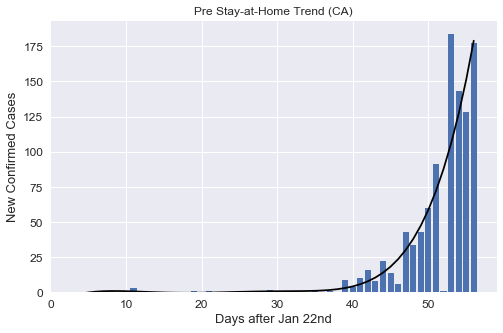

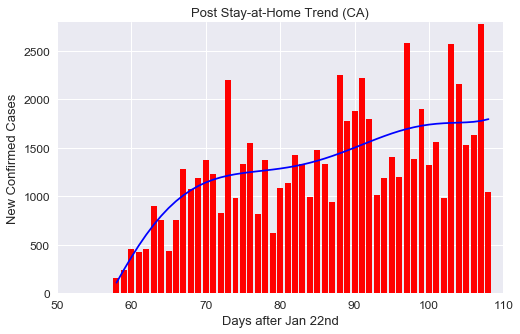

In [25]:
plt.style.use('seaborn')

plt.figure(figsize = (8,5))
plt.bar(x1, new_cases1)
plt.plot(x1, p1(x1), "k-")
plt.xlabel("Days after Jan 22nd", fontsize = 13)
plt.ylabel("New Confirmed Cases", fontsize = 13)
plt.title("Pre Stay-at-Home Trend (CA)", fontsize = 13)
plt.xlim(0,)
plt.ylim(0,)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.title("Pre Stay-at-Home Trend (CA)")

plt.figure(figsize = (8,5))
plt.bar(x2, new_cases2, color = 'r')
plt.plot(x2, p2(x2), 'b-')
plt.xlabel("Days after Jan 22nd", fontsize = 13)
plt.ylabel("New Confirmed Cases", fontsize = 13)
plt.title("Post Stay-at-Home Trend (CA)", fontsize = 13)
plt.xlim(50,110)
plt.ylim(0,2800)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.show()